# ABM results

In [ ]:
# from abetam.figures import sciencify_plotly_fig
# from abetam.config import FUEL_COLORS
# import plotly.express as px

# fig = px.bar(
#     energy_demand_df_long,
#     x="year",
#     y="value",
#     color="fuel",
#     color_discrete_map=FUEL_COLORS,
# )
# fig.update_layout(xaxis_title="Year", yaxis_title="Energy demand (kWh/a)", width=500, legend_traceorder="reversed")
# sciencify_plotly_fig(fig)


In [ ]:
# model_demand = b_res.mean_carrier_demand_df
# new_demand = add_abm_demand_to_projection(model_demand)
# abm_inkl_peaks = new_demand.max().reset_index()
# abm_inkl_peaks[["province","year"]] = abm_inkl_peaks["index"].str.split(".",expand=True)
# abm_inkl_peaks = abm_inkl_peaks.rename({0:"ABM_incl"}, axis=1).drop(["index","province"],axis=1)
# abm_inkl_peaks

In [ ]:

# both_demands = pd.concat([abm_inkl_peaks.melt(id_vars="year"),copper_demand_peaks.melt(id_vars="year")])
# fig = sciencify_plotly_fig(px.line(both_demands, x="year", y="value", color="variable", template="plotly"))
# fig.update_layout(yaxis_title="Peak demand (MW)") 

In [ ]:
# # zip all the results
# from zipfile import ZipFile, ZIP_DEFLATED
# from pathlib import Path

# with ZipFile("results.zip","w", compression=ZIP_DEFLATED, compresslevel=9) as zf:
#     for path in result_df["ABM path"]:
#         for f in path.rglob("*"):
#             zf.write(f, f)
#     for path in result_df["ESM path"]:
#         for f in path.rglob("*"):
#             zf.write(f, f)


In [ ]:
# from zipfile import ZipFile
# from pathlib import Path

# # unzip all the results
# filenames :list[str]= []
# with ZipFile("results_20240611.zip","r") as zf:
#     file_list = zf.filelist
#     for f in file_list:
#         fn = f.filename
#         zf.extract(f,)
#         filenames.append(fn)

# Results of the coupled model

In [1]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from pathlib import Path
import pandas as pd

from abetam.figures import sciencify_plotly_fig

def copper_result_dir(abm_result_dir: Path):
    scen_date, iteration = abm_result_dir.stem.rsplit("_",1)
    result_dirs = list(Path(f"copper/results/{scen_date}").iterdir())
    result_dirs = sorted(result_dirs)
    return result_dirs[int(iteration)]

abm_result_dirs = Path("results").iterdir()
date_str = "20240611"
abm_result_dirs = [d for d in abm_result_dirs if date_str in d.name]
# abm_result_dirs
result_df = pd.DataFrame(list([(d, copper_result_dir(d)) for d in sorted(abm_result_dirs)]), columns=["ABM path", "ESM path"])
result_df["iteration"] = result_df["ABM path"].apply( lambda p: p.stem.rsplit("_",1)[-1]).astype(int)

result_df["Scenario"] = result_df["ABM path"].apply( lambda p: p.stem.split("_",1)[0])

scen_mod = result_df["ABM path"].apply(lambda p: "+" if "_plus" in p.stem else "")

result_df["Scenario"] = result_df["Scenario"] + scen_mod

result_df

,ABM path,ESM path,iteration,Scenario
0,results\BAU_20240611_1437_0,copper\results\BAU_20240611_1437\BAU_scenario_...,0,BAU
1,results\BAU_20240611_1437_1,copper\results\BAU_20240611_1437\BAU_scenario_...,1,BAU
2,results\BAU_20240611_1437_2,copper\results\BAU_20240611_1437\BAU_scenario_...,2,BAU
3,results\BAU_20240611_1437_3,copper\results\BAU_20240611_1437\BAU_scenario_...,3,BAU
4,results\BAU_20240611_1437_4,copper\results\BAU_20240611_1437\BAU_scenario_...,4,BAU
5,results\BAU_20240611_1437_5,copper\results\BAU_20240611_1437\BAU_scenario_...,5,BAU
6,results\BAU_20240611_1437_6,copper\results\BAU_20240611_1437\BAU_scenario_...,6,BAU
7,results\BAU_20240611_1437_7,copper\results\BAU_20240611_1437\BAU_scenario_...,7,BAU
8,results\CER_20240611_1541_0,copper\results\CER_20240611_1541\CER_scenario_...,0,CER
9,results\CER_20240611_1541_1,copper\results\CER_20240611_1541\CER_scenario_...,1,CER


## ABM Adoption and energy demands

In [39]:
import sys 
sys.path.insert(0,"abetam")
from abetam.batch import BatchResult
import seaborn as sns
from abetam.data.canada import (
    uncertain_demand_from_income_and_province,
    get_end_use_agg_heating_share
)
from abetam.components.model import get_income_and_attitude_weights
from abetam.components.technologies import merge_heating_techs_with_share
from abetam.batch import transform_dict_column

def get_demand_reductions(n):
    dem_red = np.random.normal(0.4875, 0.125, n)
    # ensure (0,1) boundaries
    dem_red[dem_red < 0] = -dem_red[dem_red < 0]
    dem_red[dem_red > 1] = 1 - (dem_red[dem_red > 1] - 1)
    return dem_red

def mean_energy_demand(n):
    province = "Ontario"
    price_weight_mode = 0.55
    start_year=2020
    income_distribution, weights_df = get_income_and_attitude_weights(
        n, price_weight_mode=price_weight_mode
    )
    total_energy_demand = uncertain_demand_from_income_and_province(
        income_distribution, province
    )

    province_heat_share = get_end_use_agg_heating_share(province, start_year)
    heat_demand = total_energy_demand * province_heat_share
    return heat_demand.mean()

def get_scenario_retrofit_cost(abm_res):
    no_refurbishments = abm_res.results_df[["RunId","AgentID","Refurbished","Heat demand"]].drop_duplicates().groupby("RunId")["Refurbished"].sum()
    assert no_refurbishments[0] == no_refurbishments.mean()

    mean_demand = mean_energy_demand(no_refurbishments[0])
    demand_frame = abm_res.results_df[["RunId","Step","AgentID","Heat demand"]].query("Step == 0")
    demand_frame["n_households"] = demand_frame["Heat demand"]/mean_demand
    demand_frame = demand_frame.groupby("RunId").sum()
    seeds = abm_res.results_df[["RunId","random_seed"]].drop_duplicates().set_index("RunId")
    seeds["n_households"] = demand_frame["n_households"]
    no_res_buildings = 1639581 #https://open.canada.ca/data/en/dataset/7803173f-8ab7-428c-b987-74bbde245e12/resource/6cc8a832-11d5-4d9a-9796-397905490dc1
    no_households = 5.169*1e6 # https://www.ontario.ca/page/ontario-demographic-quarterly-highlights-first-quarter

    households_per_building = no_households/no_res_buildings

    max_build_work_cost = 100000
    total_retrofit_costs = pd.DataFrame()
    refurbished_share = no_refurbishments[0]/abm_res.results_df["AgentID"].max()
    for r_id, seed, n_households in seeds.itertuples():
        # _, r_id, seed = tupl
        np.random.seed(seed)
        dem_reds = get_demand_reductions(no_refurbishments[0])

        # assume maximum reduction == maximum cost
        dem_reds /= dem_reds.max()
        retrofit_costs = (dem_reds*max_build_work_cost).mean()*no_households*refurbished_share/households_per_building
        # print(n_households/households_per_building)

        total_retrofit_costs.at[r_id,"Retrofit costs (CAD)"] = retrofit_costs

    total_retrofit_costs["scenario"] = scenario
    return total_retrofit_costs


def abm_total_ann_cost(abm_res):
    N = abm_res.results_df["N"][0]
    start_year = abm_res.results_df["start_year"][0]
    province = abm_res.results_df["province"][0]
    assert len(abm_res.results_df["province"].unique()) < 2

    # get adoption details from result
    adopt_df = abm_res.adoption_details_df.pivot(index=["RunId","year"],columns="AgentID",values="tech")

    # get starting tech distribution
    heating_techs_df = merge_heating_techs_with_share(
        start_year=start_year, province=province
    ).reset_index()
    heating_techs_df["upper_idx"] = (heating_techs_df["cum_share"] * N).astype(int)

    starting_techs = [heating_techs_df.query(f"{i}<=upper_idx")["index"].iloc[0] for i in range(500)]
    start_tech_df = pd.DataFrame([starting_techs]*6, index=pd.MultiIndex.from_product([range(6),[2020.]], names=["RunId","year"]), columns=range(500))

    # add starting tech distribution to adoption df and forward fill the dataframe
    tech_agent_map = pd.concat([adopt_df, start_tech_df]).sort_index().ffill()

    # get annual cost lookup from result
    tech_ann_cost = abm_res.results_df[["year","RunId","AgentID","Technology annual_cost"]]
    tech_ann_cost = transform_dict_column(tech_ann_cost, "Technology annual_cost", return_cols=False)
    tech_ann_cost_lookup = tech_ann_cost.melt(id_vars=["year","RunId","AgentID"], ).set_index(["year","RunId","AgentID","variable"])

    def fill_costs(col):
        # apply called on a df yields a column as param here
        col_df = col.to_frame(name="variable")
        col_df["AgentID"] = col.name
        idx = pd.Index(col_df.reset_index()[["year","RunId","AgentID","variable"]])
        return tech_ann_cost_lookup.loc[idx, "value"].values

    # swap tech names with their annual costs
    ann_cost_agent_map = tech_agent_map.apply(fill_costs)

    # reduce to full years
    is_full_year = ann_cost_agent_map.reset_index()["year"]%1==0
    ann_cost_agent_map = ann_cost_agent_map.reset_index().loc[is_full_year,:].set_index(["RunId","year"])

    # sum
    total_abm_cost = ann_cost_agent_map.groupby(["RunId"]).sum().sum(axis=1)
    return total_abm_cost.to_frame(name="agg. annual costs")

def abm_cost_components(abm_res):
    cost_comps = abm_res.results_df[["AgentID","RunId","year",'Cost components','Appliance name']]
    cost_comps = transform_dict_column(cost_comps, "Cost components", return_cols=False)
    cost_comps_l = cost_comps.melt(id_vars=["AgentID","RunId","year","Appliance name"])
    # divide by 4 to account for quarter-annual resolution
    cost_comps_l = cost_comps_l.groupby(["RunId","Appliance name","variable"])["value"].sum()/4
    return cost_comps_l.reset_index()

def get_agg_fuel_demands(abm_res, scenario, keep_nth_year=5):
    # demand is a model parameter, but will be reported for each agent, too
    fuel_demand = transform_dict_column(abm_res.results_df[["RunId","year", 'Energy demand time series']], 'Energy demand time series', return_cols=False)
    duplicated = fuel_demand[["RunId","year"]].duplicated()
    fuel_demand = fuel_demand.loc[~duplicated,:]
    keep_years = fuel_demand["year"] % keep_nth_year == 0
    fuel_demand = fuel_demand.loc[keep_years,:]
    fuel_demand = fuel_demand.set_index(["RunId","year"])

    def cell_sum(col):
        return np.vstack(col.values).sum(axis=1)
        
    agg_fuel_demand = fuel_demand.apply(cell_sum)
    agg_fuel_demand_l = agg_fuel_demand.groupby(["RunId","year"]).sum().melt(ignore_index=False)
    agg_fuel_demand_l["variable"] = agg_fuel_demand_l["variable"].apply(lambda fuel:fuel.value)
    agg_fuel_demand_l["scenario"] = scenario
    return agg_fuel_demand_l



In [40]:


tech_share_dfs = []
fuel_demands = []
uncertain_fuel_demands = []
subsidy_dfs = []
emission_dfs = []
lcoh_dfs = []
spendings_dfs = []
retrofit_costs = []
abm_agg_cost = []
abm_cost_comps = []

for scenario in result_df.Scenario.unique():
    # print(scenario,":", result_df.query(f"iteration==1 and Scenario=='{scenario}'"))
    abm_res = BatchResult.from_directory(result_df.query(f"iteration==1 and Scenario=='{scenario}'")["ABM path"].values[0])
    t_share_df = abm_res.tech_shares_df
    t_share_df["scenario"] = scenario
    tech_share_dfs.append(t_share_df)

    demands = abm_res.mean_carrier_demand_df.copy()
    demands["scenario"] = scenario
    fuel_demands.append(demands)

    subs = abm_res.subsidies_df
    subs["scenario"] = scenario
    subsidy_dfs.append(subs)

    emiss = abm_res.emissions()
    emiss["scenario"] = scenario
    emission_dfs.append(emiss)

    uncertain_fuel_demands.append(get_agg_fuel_demands(abm_res, scenario))

    lcohs = pd.DataFrame.from_records(abm_res.results_df["LCOH"])
    lcohs[['year','RunId','AgentID',"Refurbished"]] = abm_res.results_df[['year','RunId','AgentID',"Refurbished"]]
    long_lcohs = lcohs.set_index(["year","RunId","AgentID","Refurbished"]).melt(ignore_index=False).reset_index().drop("AgentID", axis=1)
    long_lcohs = long_lcohs.round(2).drop_duplicates().groupby(["year","variable"]).mean().reset_index()
    long_lcohs["scenario"] = scenario
    lcoh_dfs.append(long_lcohs)

    adopt_df = abm_res.adoption_details_df.set_index(['RunId','AgentID','year',])
    adopt_df["req. size"] = abm_res.results_df[['RunId','AgentID','year','Required heating size']].set_index(['RunId','AgentID','year']).loc[adopt_df.index,'Required heating size']
    adopt_df["Purchase cost"] = adopt_df["purchase_price"] * adopt_df["req. size"]
    total_spendings = adopt_df.groupby(["RunId", "tech"])["Purchase cost"].sum().groupby("tech").mean().reset_index()
    total_spendings["scenario"] = scenario
    spendings_dfs.append(total_spendings)

    cost_comps = abm_cost_components(abm_res)
    cost_comps["scenario"] = scenario
    abm_cost_comps.append(cost_comps)

    abm_agg_annual_costs = abm_total_ann_cost(abm_res)
    abm_agg_annual_costs["scenario"] = scenario
    abm_agg_cost.append(abm_agg_annual_costs)
    retrofit_costs.append(get_scenario_retrofit_cost(abm_res))

scenario_tech_shares = pd.concat(tech_share_dfs)
scenario_fuel_demands = pd.concat(fuel_demands)
scenario_uncertain_fuel_demands = pd.concat(uncertain_fuel_demands)
scenario_emissions = pd.concat(emission_dfs)
scenario_subsidies = pd.concat(subsidy_dfs)
scenario_lcohs = pd.concat(lcoh_dfs)
scenario_spendings = pd.concat(spendings_dfs)
scenario_retrofit_costs = pd.concat(retrofit_costs)
abm_agg_costs = pd.concat(abm_agg_cost)
abm_cost_comps = pd.concat(abm_cost_comps)
scenario_retrofit_costs.head()


,Retrofit costs (CAD),scenario
2,2.684469e+10,BAU
3,2.616550e+10,BAU
1,2.970982e+10,BAU
5,2.969654e+10,BAU
0,2.839719e+10,BAU


In [6]:

rtrft_fig = px.box(scenario_retrofit_costs, x="scenario",y="Retrofit costs (CAD)", color="scenario", template="plotly", width=400,)
rtrft_fig = sciencify_plotly_fig(rtrft_fig)
rtrft_fig.update_layout(showlegend=False, margin=dict(r=10,t=10,b=10), height=350, font_family="cm",font_size=18)
rtrft_fig.write_image(f"abm_retrofit_cost_{date_str}.svg")
rtrft_fig.write_image(f"abm_retrofit_cost_{date_str}.pdf",engine="kaleido")
# rtrft_fig

In [5]:
total_cost_fig = px.box(abm_agg_costs, x="scenario",y="agg. annual costs", color="scenario", template="plotly", width=400,)
total_cost_fig = sciencify_plotly_fig(total_cost_fig)
total_cost_fig.update_layout(showlegend=False, margin=dict(r=10,t=10,b=10), height=350, font_family="cm",font_size=18, yaxis_title="Total residential cost (CAD)")
total_cost_fig.write_image(f"abm_total_cost_{date_str}.svg")
# total_cost_fig

In [ ]:
# agg_fuel_demand_l
# sns.lineplot(agg_fuel_demand_l.reset_index(), x="year",y="value", hue="variable")

In [7]:
scenario_fuel_demands_long = scenario_fuel_demands.groupby(["year","scenario"]).sum().melt(ignore_index=False).reset_index()
scenario_fuel_demands_long

,year,scenario,variable,value
0,2020.0,BAU,Fuels.NATURAL_GAS,93274035604.666656
1,2020.0,CER,Fuels.NATURAL_GAS,92711077819.583313
2,2020.0,CER+,Fuels.NATURAL_GAS,92662457111.500015
3,2020.0,Rapid,Fuels.NATURAL_GAS,92202709224.333313
4,2020.0,Rapid+,Fuels.NATURAL_GAS,92177556205.916702
...,...,...,...,...
135,2050.0,BAU,Fuels.ELECTRICITY,60968980156.166656
136,2050.0,CER,Fuels.ELECTRICITY,53596186864.166672
137,2050.0,CER+,Fuels.ELECTRICITY,60461131887.375
138,2050.0,Rapid,Fuels.ELECTRICITY,17755132449.687504


In [8]:
scenario_fuel_demands_long["value"] /= 1e9 # kWh -> TWh


In [55]:
from abetam.config import TECHNOLOGY_COLORS, FUEL_COLORS
from abetam.components.technologies import Fuels
ABM_colors = dict(TECHNOLOGY_COLORS, **FUEL_COLORS)

scenario_tech_shares_long = scenario_tech_shares.drop(["province","RunId"], axis=1).melt(id_vars=["year","scenario"]) 
abm_results = pd.concat([scenario_tech_shares_long, scenario_fuel_demands_long])
def is_fuel(v):
    return v in list(Fuels)
abm_results["is_demand"] = abm_results["variable"].apply(is_fuel)

abm_results["variable"] = abm_results["variable"].str.replace("Wood or wood pellets", "Biomass")
ABM_colors["Biomass furnace"] = ABM_colors["Wood or wood pellets furnace"]
ABM_colors["Biomass"] = ABM_colors["Wood or wood pellets"]
abm_results.tail()



,year,scenario,variable,value,is_demand
135,2050.0,BAU,Electricity,60.96898,True
136,2050.0,CER,Electricity,53.596187,True
137,2050.0,CER+,Electricity,60.461132,True
138,2050.0,Rapid,Electricity,17.755132,True
139,2050.0,Rapid+,Electricity,18.834549,True


In [47]:
scenario_uncertain_fuel_demands["value"] /= 1e9 # kWh -> TWh

In [48]:
keep_years = scenario_tech_shares_long["year"] % 2 == 0
scenario_tech_shares_long = scenario_tech_shares_long.loc[keep_years,:]
new_abm_results = pd.concat([scenario_tech_shares_long, scenario_uncertain_fuel_demands.reset_index()])
new_abm_results["is_demand"] = new_abm_results["variable"].apply(is_fuel)

new_abm_results["variable"] = new_abm_results["variable"].str.replace("Wood or wood pellets", "Biomass")

new_abm_results

,year,scenario,variable,value,RunId,is_demand
0,2020.0,BAU,Gas furnace,0.714000,NaN,False
8,2022.0,BAU,Gas furnace,0.700000,NaN,False
16,2024.0,BAU,Gas furnace,0.688000,NaN,False
24,2026.0,BAU,Gas furnace,0.676000,NaN,False
32,2028.0,BAU,Gas furnace,0.656000,NaN,False
...,...,...,...,...,...,...
835,2030.0,Rapid+,Electricity,19.173302,5.0,True
836,2035.0,Rapid+,Electricity,18.467806,5.0,True
837,2040.0,Rapid+,Electricity,18.681229,5.0,True
838,2045.0,Rapid+,Electricity,18.705082,5.0,True


In [49]:
import warnings
warnings.filterwarnings('ignore')

In [61]:
ABM_colors["Electric furnace"] = "#ae71c2"

0 False BAU 480
1 False CER 480
2 False CER+ 480
3 False Rapid 480
4 False Rapid+ 480
5 True BAU 168
6 True CER 168
7 True CER+ 168
8 True Rapid 168
9 True Rapid+ 168


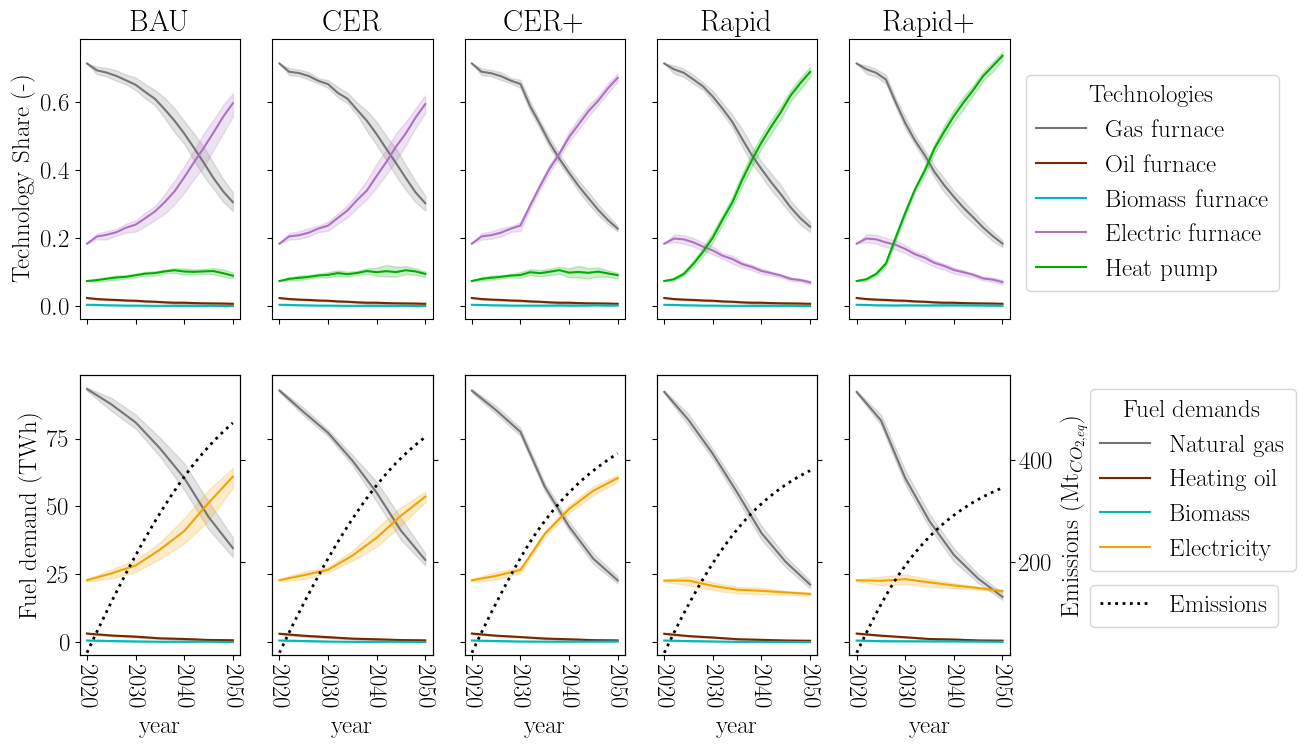

In [431]:
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "cm"
plt.rcParams["font.size"] = "18"
plt.rcParams['svg.fonttype'] = 'none'

fuel_name_map = dict(zip(Fuels, [x.value for x in Fuels]))
fuel_name_map["Biomass"] = "Biomass"

abm_fig, axs = plt.subplots(ncols=5, nrows=2,  sharex='all', sharey='row', figsize=(12,8))
for i,(dem_scen, df) in enumerate(new_abm_results.groupby(["is_demand","scenario"])):
    print(i,dem_scen[0],dem_scen[1],len(df))
    ax = axs.flat[i]
    if not dem_scen[0]:
        ax.title.set_text(f"{dem_scen[1]}")
        show_legend = i==4
        sns.lineplot(data=df, x="year", y="value", hue="variable", palette=ABM_colors, ax=ax, legend=show_legend)
        if show_legend:
            ax.legend(loc=(1.1, 0.1 ))
            ax.get_legend().set_title("Technologies")
    else:
        show_legend = i==9
        # wide_df = df.pivot(columns="variable", values="value", index="year")
        # wide_columns = wide_df.columns
        # column_vals = [wide_df[col].astype(float) for col in wide_columns]
        sns.lineplot(data=df, x="year", y="value", hue="variable", palette=ABM_colors, ax=ax, legend=show_legend)
        if show_legend:
            ax.legend(loc=(1.5, 0.3 ))
            ax.get_legend().set_title("Fuel demands")


abm_fig.axes[0].set_ylabel("Technology Share (-)")
abm_fig.axes[5].set_ylabel("Fuel demand (TWh)")
abm_fig.axes[0].set_xticks(range(2020,2051,10))

total_scenario_emissions = scenario_emissions.reset_index().groupby(["index","scenario"]).sum().sum(axis=1).reset_index()
total_scenario_emissions["cumulative"] = total_scenario_emissions.groupby("scenario").cumsum()[0]
em_y_lim = total_scenario_emissions.cumulative.min()*0.8, total_scenario_emissions.cumulative.max()*1.2
emission_color = "black"
for i, (scen, df) in enumerate(total_scenario_emissions.groupby("scenario")):
    # print(scen, df)
    last = i==4
    t_ax = axs.flat[5+i].twinx()
    t_ax.plot(df["index"],df["cumulative"], ":", color=emission_color, label="Emissions", linewidth=2)
    t_ax.set_ylim(*em_y_lim)
    t_ax.spines["right"].set_color(emission_color)
    t_ax.tick_params(colors=emission_color, which='both')
    if not last:
        t_ax.set_yticklabels([])
    else:
        t_ax.set_ylabel("Emissions (Mt$_{CO_{2,eq}}$)")
        t_ax.legend(loc=(1.5, 0.1))
        # t_ax.get_legend().set_title("Emissions (Mt)")
abm_fig.savefig(f"abm_results_{date_str}.svg")


for ax in abm_fig.axes:
    ax.set_xticklabels(range(2020,2051,10), rotation=-90)


In [51]:
# import matplotlib.pyplot as plt
# plt.rcParams["text.usetex"] = True
# plt.rcParams["font.family"] = "cm"
# plt.rcParams["font.size"] = "18"
# plt.rcParams['svg.fonttype'] = 'none'

# fuel_name_map = dict(zip(Fuels, [x.value for x in Fuels]))
# fuel_name_map["Biomass"] = "Biomass"

# abm_fig, axs = plt.subplots(ncols=5, nrows=2,  sharex='all', sharey='row', figsize=(12,8))
# for i,(dem_scen, df) in enumerate(abm_results.groupby(["is_demand","scenario"])):
#     print(i,dem_scen[0],dem_scen[1],len(df))
#     ax = axs.flat[i]
#     if not dem_scen[0]:
#         ax.title.set_text(f"{dem_scen[1]}")
#         show_legend = i==4
#         sns.lineplot(data=df, x="year", y="value", hue="variable", palette=ABM_colors, ax=ax, legend=show_legend)
#         if show_legend:
#             ax.get_legend().set_title("Technologies")
#     else:
#         show_legend = i==9
#         wide_df = df.pivot(columns="variable", values="value", index="year")
#         wide_columns = wide_df.columns
#         column_vals = [wide_df[col].astype(float) for col in wide_columns]
#         ax.stackplot(wide_df.index, *column_vals, colors=[ABM_colors[col] for col in wide_columns], labels=[fuel_name_map[col] for col in wide_columns])
#         if show_legend:
#             ax.legend(loc="lower right")
#             ax.get_legend().set_title("Fuel demands")


# abm_fig.axes[0].set_ylabel("Technology Share (-)")
# abm_fig.axes[5].set_ylabel("Fuel demand (TWh)")
# abm_fig.axes[0].set_xticks(range(2020,2051,10))
# for ax in abm_fig.axes:
#     ax.set_xticklabels(range(2020,2051,10), rotation=-90)


## ABM: subsidies

In [68]:
import plotly.express as px
subsidies_plot_df = scenario_subsidies.groupby(["year","scenario"])[["hp specific cost", "Cumulative subsidy amount (CAD)"]].mean()
# px.line(subsidies_plot_df.reset_index(), x="year", y=["Cumulative subsidy amount (CAD)","hp specific cost"], color="scenario", template="plotly", width=600)

In [69]:
scenario_spendings["tech"] = scenario_spendings["tech"].str.replace("Wood or wood pellets", "Biomass")


In [70]:
scenario_spendings.reset_index(inplace=True, drop=True)

In [71]:
def subs_fac(name):
    if "CER" in name:
        return 0.15
    elif "Rapid" in name:
        return 0.3
    else:
        return 0


subsidies = scenario_spendings.query("tech=='Heat pump' and scenario!='BAU'")
subsidies_amount = subsidies["Purchase cost"] * subsidies["scenario"].apply(subs_fac)
scenario_spendings.loc[subsidies_amount.index,"Purchase cost"] -= subsidies_amount
subsidies["Purchase cost"] = subsidies_amount.values
subsidies["tech"] = "Subsidies"
scenario_spendings = pd.concat([scenario_spendings, subsidies])

## ABM: total costs

In [74]:
ABM_colors.update({"Subsidies":"#4361ae"})
fig = sciencify_plotly_fig(
    px.bar(
        scenario_spendings,
        x="scenario",
        y="Purchase cost",
        color="tech",
        color_discrete_map=ABM_colors,
    )
)
fig.update_layout(
    yaxis_title="Total purchase cost (CAD)",
    xaxis_title="",
    legend=dict(
        title_text=None,
        # bgcolor="LightSteelBlue",
        bordercolor="gray",
        borderwidth=2,
        x=0.02,
        y=0.98,
        traceorder="reversed",
    ),
    width=500,
    font_family="cm",
    font_size=18
)
fig.write_image(f"abm_total_spendings_{date_str}.pdf")
fig.write_image(f"abm_total_spendings_{date_str}.svg")
fig

In [75]:
total_emissions = total_scenario_emissions.groupby("scenario")[0].sum()
avoided_emissions = total_emissions["BAU"] - total_emissions
total_subsidies = subsidies_plot_df.loc[2050,"Cumulative subsidy amount (CAD)"]*1e-6
carbon_avoidance_cost = total_subsidies/avoided_emissions

summary_df = pd.concat(
    [total_emissions, total_subsidies, avoided_emissions, carbon_avoidance_cost],
    axis=1,
).fillna(0).round(2)
summary_df.columns = ["Total emissions (Mt)","Total subsidies (MCAD)","Avoided emissions (Mt)","Gov. carbon avoidance cost (CAD/t)",]
print(summary_df.to_latex().replace("0000",""))

\begin{tabular}{lrrrr}
\toprule
 & Total emissions (Mt) & Total subsidies (MCAD) & Avoided emissions (Mt) & Gov. carbon avoidance cost (CAD/t) \\
scenario &  &  &  &  \\
\midrule
BAU & 473.14 & 0.00 & 0.00 & 0.00 \\
CER & 445.31 & 784.25 & 27.83 & 28.18 \\
CER+ & 412.97 & 765.26 & 60.17 & 12.72 \\
Rapid & 379.30 & 8512.13 & 93.84 & 90.71 \\
Rapid+ & 345.35 & 9580.07 & 127.79 & 74.97 \\
\bottomrule
\end{tabular}



In [ ]:
# abm_cost_comps.groupby([
#     "Appliance name",
#     "variable",
#     "scenario",
# ])["value"].mean().reset_index().pivot(index="scenario", columns=["Appliance name","variable"], values="value")
# mean_appl_cost = abm_cost_comps.groupby(["RunId","scenario","variable"])["value"].sum().groupby(["scenario","variable"]).mean().reset_index()
# mean_appl_cost["variable"] = mean_appl_cost["variable"].replace({"annuity_cost":"Invest","fom_cost":"FOM","fuel_cost":"Fuel"})
# mean_appl_cost.loc[mean_appl_cost["variable"]=="Fuel","variable"] = mean_appl_cost.query("variable=='Fuel'")["Appliance name"].apply(lambda x: tech_fuel_map.get(x).value)
# mean_appl_cost.pivot(index="scenario",columns="variable",values="value").sum(axis=1)
# px.bar(mean_appl_cost, x="scenario", y="value", color="variable", template="plotly",)

In [125]:
el_demands = scenario_uncertain_fuel_demands.query("variable=='Electricity'").drop("variable").reset_index().pivot(index=["RunId","year"],columns="scenario", values="value")

In [152]:
from abetam.scenarios import interpolate_missing_years

scen_elec_demands = scenario_fuel_demands.groupby(["year","scenario"])["Electricity"].sum().reset_index().pivot(index="year",columns="scenario",values="Electricity").reset_index()
scen_elec_demands["year"] = scen_elec_demands["year"].astype(int)
scen_elec_demands = scen_elec_demands.set_index("year")
scen_elec_demands = scen_elec_demands.astype(float).apply(interpolate_missing_years)

el_prices = pd.read_csv("scenario_price_change_over_8_iterations.csv").query("iteration==1")
scen_hoeps = el_prices.pivot(index="year", columns="scenario",values="HOEP")
scen_hoeps.loc[2020,:] = scen_hoeps.loc[2025,:]
scen_hoeps = scen_hoeps.apply(interpolate_missing_years)*1e-2 # ct/kWh -> $/kWh
scen_hoeps.tail()

scenario,BAU,CER,CER+,Rapid,Rapid+
2046,0.040665,0.048507,0.048397,0.030991,0.030890
2047,0.040601,0.048755,0.048530,0.030988,0.030912
2048,0.040538,0.049002,0.048664,0.030986,0.030933
2049,0.040474,0.049250,0.048798,0.030984,0.030955
2050,0.040411,0.049497,0.048931,0.030981,0.030976


In [310]:
scen_elec_demands

scenario,BAU,CER,CER+,Rapid,Rapid+
2020,2.285343e+10,2.282708e+10,2.279452e+10,2.267296e+10,2.275317e+10
2021,2.335099e+10,2.319898e+10,2.312360e+10,2.267357e+10,2.272569e+10
2022,2.384854e+10,2.357087e+10,2.345269e+10,2.267417e+10,2.269822e+10
2023,2.434609e+10,2.394277e+10,2.378177e+10,2.267478e+10,2.267074e+10
2024,2.484365e+10,2.431467e+10,2.411085e+10,2.267539e+10,2.264326e+10
2025,2.534120e+10,2.468656e+10,2.443994e+10,2.267599e+10,2.261578e+10
2026,2.592176e+10,2.507929e+10,2.487157e+10,2.229180e+10,2.273236e+10
2027,2.650232e+10,2.547201e+10,2.530320e+10,2.190761e+10,2.284894e+10
2028,2.708288e+10,2.586474e+10,2.573483e+10,2.152342e+10,2.296553e+10
2029,2.766344e+10,2.625746e+10,2.616646e+10,2.113922e+10,2.308211e+10


In [308]:
(scen_elec_demands*scen_hoeps).sum()

scenario
BAU       4.953554e+10
CER       5.052986e+10
CER+      5.787905e+10
Rapid     2.032613e+10
Rapid+    2.245340e+10
dtype: float64

In [317]:
scen_hoeps.index.name ="year"
dt = el_demands.reset_index()["year"].diff().median()
el_costs = (el_demands*1e9*scen_hoeps).groupby("RunId").sum()*dt # only every 5th year was counted
el_costs_mean = el_costs.mean()
# TWh->kWh  
el_costs_std = el_costs.std()

In [318]:
el_costs_l = el_costs.melt(ignore_index=False, value_name="Electricity")
el_costs_l.head()

,scenario,Electricity
RunId,,
0,BAU,6.222171e+10
1,BAU,5.907919e+10
2,BAU,5.904176e+10
3,BAU,5.812797e+10
4,BAU,5.516697e+10


In [319]:
total_subsidies = scenario_subsidies.groupby(["RunId","scenario",])["subsidy amount"].sum().to_frame(name="Subsidies")
total_subsidies.head()

Subsidies
RunId scenario              
0     BAU       0.000000e+00
      CER       7.044005e+08
      CER+      7.099372e+08
      Rapid     9.322251e+09
      Rapid+    1.021637e+10

In [320]:
abm_agg_costs = abm_agg_costs.rename({"agg. annual costs":"Appliances"}, axis=1)

In [321]:
abm_cost_summary = pd.concat(
    [
        abm_agg_costs.set_index("scenario", append=True),
        scenario_retrofit_costs.set_index("scenario", append=True).rename({"Retrofit costs (CAD)":"Retrofits"},axis=1),
        total_subsidies,
        el_costs_l.set_index("scenario", append=True),
    ],
    axis=1,
).fillna(0)
abm_cost_summary["Appliances"] -= abm_cost_summary["Electricity"]
abm_cost_summary_l = abm_cost_summary.melt(ignore_index=False)
abm_cost_summary_l.head()


,,variable,value
,scenario,,
0,BAU,Appliances,2.682882e+11
1,BAU,Appliances,2.655030e+11
2,BAU,Appliances,2.619062e+11
3,BAU,Appliances,2.590424e+11
4,BAU,Appliances,2.707568e+11


In [322]:
# px.box(abm_cost_summary_l.reset_index(), y="value", color="variable", facet_col="scenario", template="plotly",)


In [323]:
import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    se = scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h

means = abm_cost_summary_l.groupby(["scenario","variable"]).mean()
means.columns = ["mean"]
stds = abm_cost_summary_l.groupby(["scenario","variable"]).agg(mean_confidence_interval)

stds.columns = ["ci"]
results = pd.concat([means,stds], axis=1)
# results

In [410]:
ABM_colors["Appliances"] = "#7575ab"
ABM_colors["Retrofits"] = "#ff6b6b"

fig = px.bar(results.reset_index(),y="mean", color="variable", x="scenario", template="plotly", color_discrete_map=ABM_colors, width=500)
fig = sciencify_plotly_fig(fig)
fig.update_layout(legend=dict(x=.30,y=.05, title="Components", font_size=16, title_font_size=18, borderwidth=2, bordercolor="black"))
fig.update_layout(legend_traceorder="reversed", font_family="cm", font_size=18, yaxis_title="Total demand side cost (CAD)")
fig.write_image(f"abm_total_costs_{date_str}.svg")
fig.write_image(f"abm_total_costs_{date_str}.pdf")
fig

In [420]:

fig = px.bar(results.reset_index(), y="mean", color="variable", error_y="ci", x="scenario", template="plotly", width=500, barmode="group", color_discrete_map=ABM_colors)
fig = sciencify_plotly_fig(fig)
fig.update_traces(error_y={"thickness":1.2, "width":2.5})
fig.update_xaxes(showgrid=False, tickangle=90)
# fig.update_yaxes(range=(0,max(results["mean"]*1.2)))
fig.update_layout(legend=dict(x=.12,y=.55, title="Components", font_size=16, title_font_size=18, borderwidth=2, bordercolor="black"))

fig.update_layout(yaxis_title="Total demand side cost (CAD)", legend_title="Cost components", font_family="cm", font_size=18)
fig.write_image(f"abm_total_costs_uncert_{date_str}.svg")
fig.write_image(f"abm_total_costs_uncert_{date_str}.pdf")
fig

In [327]:
# n_years = 2050-2020
# no_households = 5.169*1e6

# # annuity payments
# avg_appliance_size = 10 # kW
# avg_spec_cost = 356.74 # CAD/kW #pd.read_csv("abetam/data/canada/heat_tech_params.csv", index_col=[0,1]).swaplevel().loc["specific_cost",:].mean().mean()
# annuity_factor = 0.07/(1-(1+0.07)**(-20)) # ~0.09
# annuity_payment_sum = no_households * avg_appliance_size * avg_spec_cost * annuity_factor * n_years

# # vom costs
# avg_heating_demand = 20000 # kWh/a
# avg_efficiency =  1.27 #pd.read_csv("abetam/data/canada/heat_tech_params.csv", index_col=[0,1]).swaplevel().loc["efficiency",:].mean().mean()
# avg_fuel_cost = 0.157 # CAD/kWh pd.read_csv("abetam/data/canada/residential_GNZ_end-use-prices-2023_ct_per_kWh.csv").query("GEO=='Ontario'")["Price (ct/kWh)"].mean()
# vom_cost_sum = no_households * avg_heating_demand / avg_efficiency * avg_fuel_cost * n_years

# # fom costs
# fom_cost_sum = no_households * avg_appliance_size * avg_spec_cost * 0.01 * n_years

# df = pd.DataFrame({
#     "annuity_payments":annuity_payment_sum,
#     "vom_costs":vom_cost_sum,
#     "fom_costs":fom_cost_sum
#     }, index=[0])

# px.bar(df, template="plotly",width=300)

## ABM: LCOH

In [328]:
scenario_lcohs.pivot(columns="scenario", index=["year","variable"], values="value").query("variable=='Heat pump'")

,scenario,BAU,CER,CER+,Rapid,Rapid+
year,variable,,,,,
2020.00,Heat pump,0.063750,0.056667,0.056667,0.054000,0.054000
2020.25,Heat pump,0.063750,0.060000,0.060000,0.058400,0.057692
2020.50,Heat pump,0.063750,0.060400,0.060000,0.058400,0.057692
2020.75,Heat pump,0.063750,0.060400,0.060000,0.058846,0.057692
2021.00,Heat pump,0.063333,0.060769,0.060000,0.057000,0.056552
...,...,...,...,...,...,...
2049.00,Heat pump,0.066000,0.061951,0.061429,0.061860,0.061429
2049.25,Heat pump,0.066000,0.061951,0.061429,0.061860,0.061429
2049.50,Heat pump,0.066000,0.061951,0.061429,0.061860,0.061429


In [364]:
scenario_lcohs["variable"] = scenario_lcohs["variable"].str.replace("Wood or wood pellets", "Biomass")
fig = sciencify_plotly_fig(
    px.line(
        scenario_lcohs.query("scenario=='BAU'"),
        x="year",
        y="value",
        color="variable",
        facet_col="scenario",
        template="plotly",
        color_discrete_map=ABM_colors,
        width=500
    )
)
fig.update_layout(
    yaxis_title="LCOH (CAD/kWh)",
    legend=dict(
        title_text="Technologies",
        bordercolor="gray",
        borderwidth=2,
        x=0.3,
        y=0.88,
        traceorder="reversed",
    ),
    width=500,
    font_family="cm",
    font_size=18
)
fig.write_image(f"abm_lcoh_{date_str}.svg")
fig.write_image(f"abm_lcoh_{date_str}.pdf")
fig

## Copper: demands/supplied energy

In [330]:
from copper.phases.postprocessing import get_all_supply

peak_supply_dfs = []
supply_dfs = []
supply_share_dfs = []
total_supply_dfs = []
for scenario in result_df.Scenario.unique():
    path = result_df.query(f"iteration==1 and Scenario=='{scenario}'")["ESM path"].values[0]
    sup_df = get_all_supply(path)

    total_supply = sup_df.groupby(["pds"])[["value"]].sum().reset_index()
    total_supply["scenario"] = scenario
    total_supply_dfs.append(total_supply)
    
    peak_demand = sup_df.groupby(["pds","h"])[["value"]].sum().reset_index().groupby("pds").max().reset_index().drop("h", axis=1)
    peak_demand["scenario"] = scenario
    peak_supply_dfs.append(peak_demand)

    supply_share_by_type = sup_df.groupby(["pds","Type"]).sum()/sup_df.groupby(["pds"]).sum()
    is_supply = supply_share_by_type.reset_index()["value"] > 0
    supply_share_by_type = supply_share_by_type.reset_index().loc[is_supply,:]
    supply_share_by_type["scenario"] = scenario
    supply_share_dfs.append(supply_share_by_type)
    
    sup_df["scenario"] = scenario
    supply_dfs.append(sup_df)

scen_supply_df = pd.concat(supply_dfs)
scen_total_demand_df = pd.concat(total_supply_dfs)    
scen_peak_supply_df = pd.concat(peak_supply_dfs)
scen_supply_share_df = pd.concat(supply_share_dfs)    

In [331]:
sup_df = get_all_supply("copper/results/BAU_scenario_20240513_1405")
copper_demand_peaks_long = sup_df.groupby(["pds","h"]).sum().groupby("pds").max().reset_index()
copper_demand_peaks_long["scenario"] = "COPPER projection"

In [421]:
from main import add_abm_demand_to_projection, spread_model_demand
demands = []
for scenario, scen_df in scenario_fuel_demands.groupby("scenario"):
    scen_name = "BAU_scenario" if scenario=="BAU" else "CER_scenario"
    demand_projection = add_abm_demand_to_projection(scen_df, scen_name).max().reset_index()
    demand_projection["pds"] = demand_projection["index"].str.split(".", expand=True)[1].astype(int)
    demand_projection["scenario"] = scenario
    demands.append(demand_projection)

scen_peak_demand_df = pd.concat(demands).rename({0:"value"}, axis=1).drop("index", axis=1)
scen_peak_demand_df.head()


,value,pds,scenario
0,19940.453020,2020,BAU
1,22083.588356,2025,BAU
2,26946.111536,2030,BAU
3,34359.754845,2035,BAU
4,41618.050380,2040,BAU


In [333]:
peaks_df = pd.concat([scen_peak_demand_df, copper_demand_peaks_long])
peaks_df["value"] /= 1e3
peaks_df["province"] = "Ontario"

peak_fig = sciencify_plotly_fig(px.line(peaks_df, x="pds",y="value",color="scenario", facet_col="province", template="plotly", width=500))
peak_fig.update_layout(
    yaxis_title="Peak demand (GW)",
    xaxis_title=None,
    legend=dict(
        title_text=None,
        x=0.01,
        y=0.99,
        # bgcolor="grey"
        bordercolor="grey",
        borderwidth=2,
    ),
    width=500,
    font_family="cm",
    font_size=18
)
peak_fig.write_image(f"peak_demands_{date_str}.svg")
peak_fig.write_image(f"peak_demands_{date_str}.pdf")
peak_fig


In [334]:
wide_peaks = peaks_df.pivot(columns="scenario", index="pds", values="value")
(wide_peaks.loc[2050,:]-wide_peaks.loc[2050,"COPPER projection"])/wide_peaks.loc[2050,"COPPER projection"]

scenario
BAU                  0.552192
CER                  0.490606
CER+                 0.547940
COPPER projection    0.000000
Rapid                0.245834
Rapid+               0.245999
Name: 2050, dtype: float64

In [335]:
from viz.copper import tech_agg

def get_nice_tech_name(key):
    try:
        nice_name = tech_agg[key]
    except KeyError as ke:
        nice_name = key
    
    return nice_name


scen_supply_share_df["Generator"] = scen_supply_share_df.Type.apply(get_nice_tech_name)
scen_supply_share_df = scen_supply_share_df.groupby(["pds","Generator","scenario"])[["value"]].sum().reset_index()


In [336]:
scen_supply_share_df.query("pds==2025").pivot(columns="scenario",index="Generator",values="value")

scenario,BAU,CER,CER+,Rapid,Rapid+
Generator,,,,,
Fossil fuel gas,0.063338,0.010153,0.009906,0.008118,0.008084
Hydro,0.126807,0.132906,0.133161,0.135020,0.135085
Nuclear,0.500099,0.649432,0.652293,0.672402,0.673142
Solar,0.005328,0.005584,0.005594,0.005673,0.005675
Wind,0.304427,0.201926,0.199045,0.178787,0.178014


In [337]:
scen_supply_share_df.query("pds==2050").pivot(columns="scenario",index="Generator",values="value")

scenario,BAU,CER,CER+,Rapid,Rapid+
Generator,,,,,
Biomass,NaN,0.001745,0.001706,0.001114,0.001128
Fossil fuel gas,0.179649,0.004929,0.005276,NaN,NaN
Hydro,0.029990,0.035234,0.034491,0.037178,0.037173
Hydrogen - blue,NaN,0.061563,0.063930,NaN,NaN
Hydrogen - green,NaN,NaN,NaN,0.001137,0.000932
Nuclear,0.071293,0.071105,0.067710,0.107768,0.110310
Solar,0.046533,0.077365,0.087274,0.061162,0.067728
Wind,0.672534,0.748059,0.739612,0.791640,0.782728


In [338]:
import plotly.express as px
from abetam.figures import sciencify_plotly_fig
from viz.copper import IDEA_COLORS

gen_sharefig = px.area(scen_supply_share_df, x="pds", y="value", color="Generator", facet_col="scenario", template="plotly", width=900, color_discrete_map=IDEA_COLORS)
gen_sharefig.for_each_trace(lambda trace: trace.update(fillcolor = trace.line.color, line_width=0))
gen_sharefig = sciencify_plotly_fig(gen_sharefig)
gen_sharefig = gen_sharefig.update_layout(
    yaxis_title="Generation share (-)",
    xaxis1_title="year",
    xaxis2_title="year",
    xaxis3_title="year",
)

In [339]:
# # scale with no. rundays
# scen_total_demand_df["value"] *= 365/12
# # px.line(scen_total_demand_df, x="pds", y="value", color="scenario", template="plotly", width=700)

In [340]:
# scen_peak_demand_df["demand_type"] = "Peak demand"
# scen_total_demand_df["demand_type"] = "Total demand"
# fig = px.line(pd.concat([scen_peak_demand_df, scen_total_demand_df]), x="pds", y="value", color="scenario", facet_row="demand_type", template="plotly", width=600)
# fig = fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
# fig.update_yaxes(matches=None)

In [341]:
import plotly.express as px

# total_demand["h"] = total_demand["h"].astype("str")
#px.line(total_demand, x="h", y="value", color="pds", template="plotly")

## Copper installed capacity

In [342]:
from viz.copper import tech_agg, IDEA_COLORS
import pandas as pd
gridcell_data = pd.read_csv('copper/scenarios/static/gridcells.csv')
map_gl_to_ba=dict(gridcell_data[['grid_cell', 'ba']].values)


def get_capacity_frame(results_dir):
    capacitiy_files = list(Path(results_dir).glob("capacity_*"))
    generation_dfs = []
    therm_df = None
    transmission_df = None
    storage_df = None
    for f in capacitiy_files:
        if "transmission" in f.as_posix():
            transmission_df = pd.read_csv(f)
            assert transmission_df["value"].sum() == 0
        elif "storage" in f.as_posix():
            storage_df = pd.read_csv(f).rename({"st":"type"}, axis=1)
            storage_df["gl"] = None
            generation_dfs.append(storage_df)
        else:
            df = pd.read_csv(f)
            gen_type = f.stem.split("_",1)[-1]
            if "tplants" in df.columns:
                therm_df = df.copy()
                df = df.rename({"tplants":"type"}, axis=1)
                df["gl"] = None
            else:
                df["type"] = gen_type
                df["aba"] = df["gl"].apply(map_gl_to_ba.get)
            # print(gen_type, df.columns)
            generation_dfs.append(df)
    retire_df = pd.read_csv(Path(results_dir)/"retire_therm.csv").rename({"tplants":"type"}, axis=1)
    retire_df["type"] = retire_df["type"] + "_retire"
    gen_cap_df = pd.concat(generation_dfs + [retire_df])
    return gen_cap_df

def simplify_unit_name(name, use_idea=False):
    if use_idea:
        return tech_agg.get(name)
    split = name.rsplit("_", 1)
    if len(split) == 1:
        return name

    head, tail = split
    if tail in ["SMR", "ofs", "ons", "LI", "PH"]:
        return name
    elif "_recon" in head:
        return head.rsplit("_", 1)[0]
    elif "gas" in head:
        if "retire" in head:
            return "gas_retire"
        elif "backup" in head:
            return "gas_backup"
        else:
            return "gas"
    else:
        return head

def post_process_gen_cap(gen_cap_df, use_idea=False):
    
    gen_cap_df["Generator"] = gen_cap_df.type.apply(simplify_unit_name, use_idea=use_idea)
    gen_cap_df["province"] = gen_cap_df["aba"].str.split(".", expand=True)[0]
    ba_cap_df = (
        gen_cap_df.groupby(["province", "pds", "Generator"])["value"].sum().reset_index()
    )

    # remove generators that aren't built
    keep_types = ba_cap_df.groupby(["pds", "Generator"])["value"].sum() > 0

    keep_types = keep_types  # & keep_names
    ba_cap_df = ba_cap_df.set_index(["pds", "Generator"]).loc[keep_types, :].reset_index()

    ba_cap_df["type"] = ba_cap_df["Generator"]
    keep_names = ~ba_cap_df.set_index(["pds", "Generator"])["type"].str.contains("retire")
    ba_cap_df.set_index(["pds", "Generator"], inplace=True)
    ba_cap_df.loc[keep_names, "cap_type"] = "invested"
    ba_cap_df.loc[~keep_names, "cap_type"] = "retired"

    ba_cap_df.reset_index(inplace=True)
    ba_cap_df.rename({"value": "Capacity (GW)"}, axis=1, inplace=True)
    ba_cap_df["Capacity (GW)"] /= 1000
    return ba_cap_df



In [343]:
def get_sign(t):
    if "retire" in t:
        return -1
    else:
        return 1

cap_dfs = []
for scenario in result_df.Scenario.unique():
    path = result_df.query(f"iteration==1 and Scenario=='{scenario}'")["ESM path"].values[0]
    cap_df = get_capacity_frame(path)
    ba_cap_df = post_process_gen_cap(cap_df, use_idea=True)
    ba_cap_df["Capacity (GW)"] *= ba_cap_df["Generator"].apply(get_sign)
    ba_cap_df["scenario"] = scenario
    cap_dfs.append(ba_cap_df)

cap_df = pd.concat(cap_dfs)
cap_df.head()

,pds,Generator,province,Capacity (GW),type,cap_type,scenario
0,2025,Fossil fuel gas,Ontario,1.602524,Fossil fuel gas,invested,BAU
1,2025,Fossil fuel gas - retired,Ontario,-4.129120,Fossil fuel gas - retired,retired,BAU
2,2025,Wind,Ontario,3.911011,Wind,invested,BAU
3,2030,Fossil fuel gas,Ontario,6.918497,Fossil fuel gas,invested,BAU
4,2030,Fossil fuel gas - retired,Ontario,-2.293680,Fossil fuel gas - retired,retired,BAU


In [344]:
cum_cap_df = cap_df.groupby(["scenario","Generator"])["Capacity (GW)"].sum().reset_index().pivot(columns="scenario",index="Generator",values="Capacity (GW)").fillna(0)
cum_cap_df

scenario,BAU,CER,CER+,Rapid,Rapid+
Generator,,,,,
Biomass,0.000000,0.245300,0.245300,0.245300,0.245300
Fossil fuel gas,27.319271,3.679032,4.028618,0.000000,0.000000
Fossil fuel gas - retired,-8.210800,-6.664800,-5.167800,-6.989800,-6.989800
Hydrogen - blue,0.000000,15.622811,16.596096,0.000000,0.000000
Hydrogen - green,0.000000,0.000000,0.000000,1.281765,1.103897
LI Storage,3.451541,3.209474,3.431117,12.312242,13.139795
Nuclear,0.000000,0.000000,0.000000,5.690344,5.909669
Nuclear - retired,-4.660000,-4.660000,-4.660000,-4.660000,-4.660000
PH Storage,0.283600,0.283600,0.283600,0.283600,0.283600


In [345]:
((cum_cap_df["CER+"] - cum_cap_df["CER"])/cum_cap_df["CER"]*100).reset_index()

,Generator,0
0,Biomass,0.000000
1,Fossil fuel gas,9.502131
2,Fossil fuel gas - retired,-22.461289
3,Hydrogen - blue,6.229895
4,Hydrogen - green,NaN
5,LI Storage,6.905903
6,Nuclear,NaN
7,Nuclear - retired,-0.000000
8,PH Storage,0.000000
9,Solar,3.926381


In [381]:
IDEA_COLORS

{'Fossil fuel gas': '#ff6b6b',
 'Fossil fuel gas - retired': '#784315',
 'Fossil fuel gas CCS': '#ffaaa3',
 'Fossil fuel gas backup': '#ffcbc5',
 'Fossil fuel liquid': '#ffaa33',
 'Fossil fuel liquid bio': '#ffcc66',
 'Fossil fuel liquid backup': '#ffe5a7',
 'Fossil fuel solid': '#b15928',
 'Fossil fuel solid CCS': '#8b4513',
 'Hydro': '#a6cee3',
 'Hydrogen - green': '#2de35e',
 'Hydrogen - blue': '#2496e3',
 'PH Storage': '#6a3d9a',
 'LI Storage': '#B39DE3',
 'Wind': '#b2df8a',
 'biomass': '#33a02c',
 'Biomass': '#33a02c',
 'nuclear': '#ff7f00',
 'Nuclear': '#ff7f00',
 'Nuclear - retired': '#ff7f00',
 'solar': '#ffff99',
 'Solar': '#ffff99',
 'DR': '#b8860b',
 'Other': '#d9a670',
 'Under 25 MW': '#cab2d6',
 'Imports': '#666666',
 'Imports from USA': '#666666',
 'Capacity Imports': '#666666',
 'Exports': '#b3b4b2',
 'Exports to USA': '#b3b4b2',
 'Capacity Exports': '#b3b4b2',
 'RNG': '#1f78b4',
 'Total': '#000000'}

In [346]:
from abetam.figures import sciencify_plotly_fig
import plotly.express as px
scen_cap_fig = sciencify_plotly_fig(px.bar(cap_df, x="pds", y="Capacity (GW)", color="Generator", facet_col="scenario", color_discrete_map=IDEA_COLORS))


### Emissions


In [347]:
import toml
def get_year_frac(res_path:Path):
    config = toml.load(res_path.joinpath("config.toml"))
    year_frac = len(config["Simulation_Settings"]["run_days"])/365
    return year_frac

result_df["ESM year_frac"] = result_df["ESM path"].apply(get_year_frac)

if len(result_df["ESM year_frac"].unique())>1:
    def add_year_frac(scen_name):
        frac = result_df.query(f"Scenario=='{scen_name}' and iteration==1")["ESM year_frac"]
        return frac
    scen_supply_df["year_frac"] = scen_supply_df["scenario"].apply(add_year_frac)
else:
    scen_supply_df["year_frac"] = result_df["ESM year_frac"][0]
gen_type_df = pd.read_csv("copper/scenarios/BAU_Scenario/generation_type_data.csv", index_col=0)
scen_supply_df["emissions (Mt)"] = (scen_supply_df["value"]/scen_supply_df["year_frac"]*gen_type_df["fuel_co2"]) / 1e6
scen_supply_agg = scen_supply_df.groupby(["scenario","pds"])["emissions (Mt)"].sum().groupby("scenario").cumsum().reset_index()

In [427]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

nb_rows = 2  # the number of rows in your plot
nb_cols = 5  # the number of columns in your plot
copper_fig = make_subplots(
    rows=nb_rows,
    cols=nb_cols,
    shared_xaxes=True,
    vertical_spacing=0.05,
    horizontal_spacing=0.05,
    subplot_titles=("BAU", "CER", "CER+", "Rapid", "Rapid+"),
    specs=[[{"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}],
            [{"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}]])


legend_entries = []
for i, data in enumerate(gen_sharefig.data):
    xax = data["xaxis"].replace("x", "")
    xax = 1 if xax == "" else int(xax)
    data["legendgroup"] = "gentechs"
    data["legendgrouptitle_text"] = "Technologies"
    name = data["name"]
    show_legend = name not in legend_entries
    if show_legend:
        legend_entries.append(name)
    data["showlegend"] = show_legend
    copper_fig.add_trace(data, col=xax, row=1, secondary_y=False)

for i, (scen, emission_data) in enumerate(scen_supply_agg.groupby("scenario")):
    xax=i+1
    copper_fig.add_trace(
        go.Scatter(x=emission_data["pds"], y=emission_data["emissions (Mt)"], mode='lines', showlegend=False, line_dash="dot"),
        col=xax,
        row=1,
        secondary_y=True
    )

for i, data in enumerate(scen_cap_fig.data):
    xax = data["xaxis"].replace("x", "")
    xax = 1 if xax == "" else int(xax)
    data["legendgroup"] = "gentechs"
    # data["legendgrouptitle_text"] = "Generators"
    name = data["name"]
    show_legend = name not in legend_entries
    if show_legend:
        legend_entries.append(name)
    data["showlegend"] = show_legend
    copper_fig.add_trace(data, col=xax, row=2)


def y_ax_fmt(yax):
    yax.showgrid = False
    yax.matches = "y2"
    yax.showticklabels = yax["overlaying"] == "y9"
    yax.rangemode = "tozero"
    if yax.showticklabels:
        yax.title = "Emissions (Mt)"

copper_fig.for_each_yaxis(y_ax_fmt, row=1, secondary_y=True)   
copper_fig.for_each_yaxis(lambda yax: yax.update(matches="y", showticklabels=yax.plotly_name=="yaxis"), row=1, secondary_y=False)
copper_fig.for_each_yaxis(lambda yax: yax.update(matches="y11", showticklabels=yax.plotly_name=="yaxis11"), row=2, secondary_y=False)

sciencify_plotly_fig(copper_fig)

copper_fig.update_layout(
    barmode="relative",
    width=900,
    height=600,
    yaxis1_title="Generation share (-)",
    yaxis11_title="Modified Capacity (GW)",
    xaxis6_title="Year",
    xaxis7_title="Year",
    xaxis8_title="Year",
    xaxis9_title="Year",
    xaxis10_title="Year",
    font_family="cm",
    font_size=18,
    legend_traceorder="reversed",
)
copper_fig.write_image(f"copper_results_{date_str}.svg")
copper_fig


In [349]:
scen_supply_df.set_index("scenario",append=True, inplace=True)

In [350]:
scen_demands = ((scen_supply_df["value"]/scen_supply_df["year_frac"]).groupby(["pds","scenario","Type"]).sum()*1e-6).reset_index() # MWh -> TWh
scen_demands.pivot(columns="scenario",index=["pds","Type"], values=0)

scenario                            BAU         CER        CER+       Rapid  \
pds  Type                                                                     
2025 biomass                   0.000000    0.000000    0.000000    0.000000   
     coal_ccs_pre2025          0.000000    0.000000    0.000000    0.000000   
     coal_pre2025              0.000000    0.000000    0.000000    0.000000   
     coal_retire_pre2025       0.000000    0.000000    0.000000    0.000000   
     diesel_backup_post2025    0.000000    0.000000    0.000000    0.000000   
...                                 ...         ...         ...         ...   
2050 nuclear                  24.886037   23.710216   23.096356   27.604887   
     nuclear_SMR               0.000000    0.000000    0.000000    4.148063   
     solar                    16.243231   25.797785   29.769962   18.020997   
     wind_ofs                  0.000000    0.000000    0.000000    0.000000   
     wind_ons                234.758726  249.443435  252.288848  233.251027   

scenario                         Rapid+  
pds  Type                                
2025 biomass                   0.000000  
     coal_ccs_pre2025          0.000000  
     coal_pre2025              0.000000  
     coal_retire_pre2025       0.000000  
     diesel_backup_post2025    0.000000  
...                                 ...  
2050 nuclear                  27.495303  
     nuclear_SMR               5.098608  
     solar                    20.012009  
     wind_ofs                  0.000000  
     wind_ons                231.277133  

[258 rows x 5 columns]

# Copper results

* underlying data is already annuitized and inflation adjusted
* variable costs are scaled up to represent annual cost
* fixed cost are in $/a


## System costs

In [351]:
import toml
import pandas as pd
# from main import get_copper_el_prices, multi_index_copper_demand
from copper.phases.postprocessing import get_all_disc_coeffs
import plotly.express as px

scenario = "CER_scenario"
result_dirs = [
    "copper/results/CER_20240408_1526/CER_scenario_20240408_1540"
]

results_dir = result_dirs[0]
config_path = f"{results_dir}/config.toml"
config = toml.load(config_path)
gridcell_data = pd.read_csv('copper/scenarios/static/gridcells.csv')
map_gl_to_ba=dict(gridcell_data[['grid_cell', 'ba']].values)

disc_coeffs = get_all_disc_coeffs(config)




In [352]:
disc_coeff_series = pd.Series(disc_coeffs).to_frame()
disc_coeff_series.columns = ["dual_price"]
disc_coeff_series.index.set_names(["year"], inplace=True)
disc_coeff_series.index = disc_coeff_series.index.astype(int)
disc_coeff_series

,dual_price
year,
2025,4.016778
2030,3.343079
2035,2.782374
2040,2.315710
2045,1.927316
2050,0.000100


In [353]:
import plotly.express as px
def uncumulate_values(df:pd.DataFrame):
    diff = df[["value"]].diff()
    df.loc[df.pds > 2025,"value"] = diff.loc[df.pds>2025,"value"].values
    df.loc[df["value"]<0,"value"] = 0
    return df

pds_cost_factor = {
    2025:5,
    2030:5,
    2035:5,
    2040:5,
    2045:5,
    2050:1,
}

def copper_total_cost_df(result_dir, uncumulate=False, discounted=False):
    cap_cost = pd.read_csv(f"{result_dir}/capcost.csv")
    cap_cost["cost"] = "Invest"
    fom_cost = pd.read_csv(f"{result_dir}/fixOMcost.csv")
    fom_cost["cost"] = "FOM"
    vom_cost = pd.read_csv(f"{result_dir}/varOMcost.csv")
    vom_cost["cost"] = "VOM"
    fuel_cost = pd.read_csv(f"{result_dir}/fuel_cost.csv")
    fuel_cost["cost"] = "Fuels"
    storage_cost = pd.read_csv(f"{result_dir}/newstorage_ccost.csv")
    storage_cost["cost"] = "Storage Invest"
    storage_om_cost = pd.read_csv(f"{result_dir}/newstorage_omcost.csv")
    storage_om_cost["cost"] = "Storage OM"
    hydro_cost = pd.read_csv(f"{result_dir}/hydrorenewalccost.csv")
    hydro_cost["cost"] = "Hydro"
    hydro_om_cost = pd.read_csv(f"{result_dir}/hydrorenewalomcost.csv")
    hydro_om_cost["cost"] = "Hydro"
    if uncumulate:
        cap_cost = uncumulate_values(cap_cost)
        fom_cost = uncumulate_values(fom_cost)
        storage_cost = uncumulate_values(storage_cost)
        storage_om_cost = uncumulate_values(storage_om_cost)
        hydro_cost = uncumulate_values(hydro_cost)
        hydro_om_cost = uncumulate_values(hydro_om_cost)

    total_cost = pd.concat([cap_cost, vom_cost, fom_cost,fuel_cost,storage_cost,storage_om_cost,hydro_cost,hydro_om_cost])
    if discounted:
        total_cost["value"] *= total_cost["pds"].astype(str).apply(disc_coeffs.get)
    else:
        total_cost["value"] *= total_cost["pds"].apply(pds_cost_factor.get)
    return total_cost   

total_cost = copper_total_cost_df(results_dir, uncumulate=False)
total_cost["cost_type"] = "undiscounted"
total_adapted_cost = copper_total_cost_df(results_dir, uncumulate=False, discounted=True)
total_adapted_cost["cost_type"] = "discounted"


total_cost = pd.concat([total_cost, total_adapted_cost])

# total_cost
fig = px.bar(total_cost, x="pds", y="value",color="cost", facet_row="cost_type", template="plotly")
fig.update_layout(width=700, legend_traceorder="reversed")
fig.write_html(f"{results_dir}/investments_{date_str}.html")
fig.write_image(f"{results_dir}/investments_{date_str}.png")
fig

In [354]:
total_cost.groupby("cost_type")["value"].sum()

cost_type
discounted      1.276989e+11
undiscounted    2.643493e+11
Name: value, dtype: float64

In [424]:
cost_dfs = []
for scenario in result_df.Scenario.unique():
    path = result_df.query(f"iteration==1 and Scenario=='{scenario}'")[
        "ESM path"
    ].values[0]
    cost_df = copper_total_cost_df(path)
    cost_df["scenario"] = scenario
    cost_dfs.append(cost_df)

scen_cost_df = pd.concat(cost_dfs)
scen_cost_agg = (
    scen_cost_df.groupby(["scenario", "cost"])["value"]
    .sum()
    .reset_index()
    .pivot(columns="scenario", index="cost", values="value")
)
fig = sciencify_plotly_fig(px.bar(scen_cost_agg.T, template="plotly", color_discrete_map=IDEA_COLORS))

fig.update_layout(
    yaxis_title="Cumulative cost (CAD)", width=400, font_family="cm", font_size=18,
    legend=dict(title_text="Cost component", font_size=16, title_font_size=18,),# borderwidth=2, bordercolor="black"),
    legend_traceorder="reversed"
)
fig.write_image(f"copper_system_cost_{date_str}.svg")
fig.write_image(f"copper_system_cost_{date_str}.pdf")
fig

In [356]:
scen_copper_emissions_agg = scen_supply_df.groupby("scenario")["emissions (Mt)"].sum()
scen_copper_emissions_reduction = scen_copper_emissions_agg["BAU"] - scen_copper_emissions_agg
scen_copper_emissions_reduction

scenario
BAU        0.000000
CER       68.698610
CER+      68.315838
Rapid     75.007339
Rapid+    74.997955
Name: emissions (Mt), dtype: float64

In [357]:
scen_cost_agg.sum()*1e-6/scen_copper_emissions_reduction

scenario
BAU               inf
CER       4276.163109
CER+      4510.279408
Rapid     3921.229402
Rapid+    3979.505031
dtype: float64

In [358]:
coupled_cost = scen_cost_agg.sum() + abm_cost_summary.sum(axis=1) - el_costs
coupled_cost_delta = coupled_cost - coupled_cost["BAU"]
coupled_emissions_reduction = scen_copper_emissions_reduction + avoided_emissions
coupled_cost_delta*1e-6/coupled_emissions_reduction

KeyError: 'BAU'

In [ ]:
coupled_overview = pd.concat([
            scen_cost_agg.sum()*1e-9,
            scen_copper_emissions_reduction,
            scen_cost_agg.sum()*1e-6/scen_copper_emissions_reduction,
            coupled_cost*1e-9,
            coupled_emissions_reduction,
            coupled_cost_delta*1e-6/coupled_emissions_reduction], axis=1)
coupled_overview.columns = ["ESM total cost (BCAD)", "ESM emissions reduction (Mt)", "ESM carbon avoidance cost (CAD/t)", "Coupled cost (BCAD)", "Coupled emissions reduction (Mt)", "Coupled carbon avoidance cost (CAD/t)"]

In [ ]:
print(coupled_overview.fillna(0).round(2).to_latex().replace("0000",""))